In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Dict, Any
import seaborn
import pandas
import copy
from sklearn.neighbors import NearestNeighbors
from datasets import load_dataset
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler


In [2]:
import pandas as pd

MergedDataset = pd.read_csv("dataset/engineered_df.txt")
MergedDataset.head(10)

,name_cyclist,birth_year,weight,height,nationality,expected_url,name_race,points,uci_points,length,...,pca_race_points,weight_height_ratio,physical_score,race_difficulty,points_per_km,startlist_per_km,combined_score_per_km,consistency_score,position_modified,race_performance_score
0,bruno-surra,1964.0,64.634124,168.325999,Italy,bruno--surra,vuelta-a-espana/1989/stage-1,0.0,0.0,20100.0,...,-0.268712,0.383982,10.230389,68.41350,-0.013369,39.950249,15.972078,0.000000,77,53.895989
1,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1997/stage-2,0.0,0.0,262000.0,...,-0.268712,0.406593,13.043956,866.24350,-0.001026,7.610687,3.043659,168.935081,63,44.099692
2,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1990/stage-1,0.0,0.0,138500.0,...,-0.268712,0.406593,10.243956,456.59450,-0.001940,14.144404,5.656598,168.935081,131,91.699418
3,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1992/stage-7,0.0,0.0,196500.0,...,-0.268712,0.406593,11.043956,649.17900,-0.001367,10.417303,4.166101,168.935081,148,103.599590
4,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1990/stage-9,0.0,0.0,196000.0,...,-0.268712,0.406593,10.243956,649.50175,-0.001371,9.994898,3.997137,168.935081,142,99.399589
5,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,la-fleche-wallone/1996/result,5.0,8.0,200500.0,...,0.171768,0.406593,12.643956,668.96050,0.000857,4.793017,1.917721,168.935081,60,42.000257
6,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1991/stage-12,8.0,1.0,192000.0,...,0.127537,0.406593,10.643956,645.00150,0.000664,10.067708,4.027482,168.935081,170,119.000199
7,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1989/stage-17,0.0,0.0,165000.0,...,-0.268712,0.406593,9.843956,562.50150,-0.001629,11.206061,4.481447,168.935081,118,82.599511
8,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1997/stage-5,0.0,0.0,261300.0,...,-0.268712,0.406593,13.043956,860.83950,-0.001028,7.631075,3.051813,168.935081,83,58.099691
9,gerard-rue,1965.0,74.000000,182.000000,France,gerard--rue,tour-de-france/1992/stage-15,0.0,0.0,198000.0,...,-0.268712,0.406593,11.043956,657.47700,-0.001357,10.338384,4.134539,168.935081,103,72.099593


new features:
- weight_height_ratio = weight / height
- physical_score = weight_height_ratio * 0.6 + cyclist_age' * 0.4
- race_difficulty = (length * 0.325 + climb_total * 0.525 + is_tarmac * 0.15) /100
- pca_race_points = merging di points euci_points usando l'algo PCA
- points_per_km = pca_race_points / length * 0.001
- startlist_per_km = startlist_quality / 0.001
- combined_score_per_km = 0.6 * points_per_km + 0.4 * startlist_per_km
- position_modified = max_position - position
- race_performance_score = position_modified * 0.7 + points_per_km * 0.3

In [3]:
clustering_features = MergedDataset[[
    'physical_score', 'race_difficulty', 
    'combined_score_per_km', 'race_performance_score'
]].iloc[0:10000]

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(clustering_features)
data_scaled = scaler.transform(clustering_features)

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import numpy as np
import itertools

eps_values = np.arange(0.2, 2.5, 0.3)
min_samples_values = [50, 100, 150, 200]
metrics = ['euclidean', 'manhattan', 'cosine', 'chebyshev']

best_score = -1
best_params = {}

for eps, min_samples, metric in itertools.product(eps_values, min_samples_values, metrics):
    try:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        labels = dbscan.fit_predict(data_scaled)

        # Verifica se ci sono almeno 2 cluster
        if len(set(labels)) > 1:
            score = silhouette_score(data_scaled, labels)

            # Aggiorna i migliori parametri se il punteggio è migliorato
            if score > best_score:
                best_score = score
                best_params = {
                    'eps': eps,
                    'min_samples': min_samples,
                    'metric': metric,
                    'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
                }
    except Exception as e:
        print(f"Errore con eps={eps}, min_samples={min_samples}, metric={metric}: {e}")

print(f"\nMiglior combinazione trovata:")
print(f"eps: {best_params['eps']}")
print(f"min_samples: {best_params['min_samples']}")
print(f"metric: {best_params['metric']}")
print(f"Numero di cluster: {best_params['n_clusters']}")
print(f"Silhouette Score: {best_score:.4f}")



Miglior combinazione trovata:
eps: 1.7
min_samples: 50
metric: chebyshev
Numero di cluster: 1
Silhouette Score: 0.8512


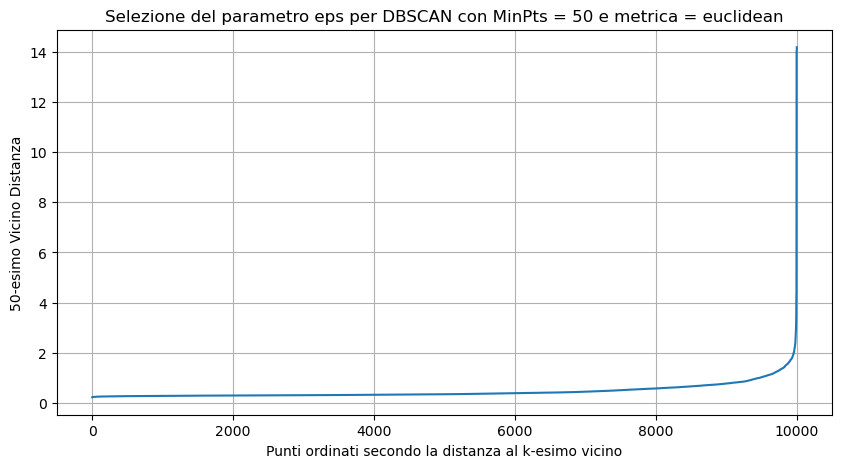

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Parametri
k = 50  # Numero minimo di punti per formare un cluster (MinPts)
metric = 'chebyshev'  # Cambia la metrica qui (es. 'euclidean', 'manhattan', 'chebyshev', 'cosine')

# Calcolo della distanza del k-esimo vicino utilizzando la metrica scelta
nearest_neighbors = NearestNeighbors(n_neighbors=k, metric=metric)
nearest_neighbors.fit(data_scaled)
distances, indices = nearest_neighbors.kneighbors(data_scaled)

# Ordinamento delle distanze del k-esimo vicino
kth_distances = np.sort(distances[:, k-1])

# Plot della curva per individuare il valore di 'eps'
plt.figure(figsize=(10, 5))
plt.plot(kth_distances)
plt.xlabel("Punti ordinati secondo la distanza al k-esimo vicino")
plt.ylabel(f"{k}-esimo Vicino Distanza")
plt.title(f"Selezione del parametro eps per DBSCAN con MinPts = {k} e metrica = {metric}")
plt.grid(True)
plt.show()


DBSCAN

In [39]:
from sklearn.cluster import DBSCAN

eps_value = 1.7  # valore scelto in base al grafico
dbscan = DBSCAN(eps=eps_value, min_samples=k)
dbscan.fit(data_scaled)


DBSCAN(eps=1.7, min_samples=50)

In [40]:
# Controlla la distribuzione dei cluster
labels =dbscan.labels_
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Numero di punti per ciascun cluster:", cluster_counts)

Numero di punti per ciascun cluster: {-1: 17, 0: 9983}


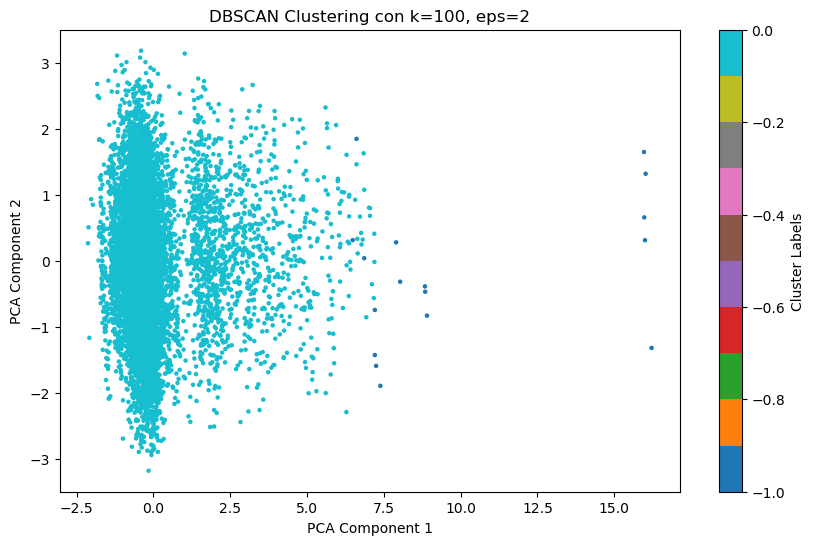

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan.labels_, cmap='tab10', s=5)
plt.colorbar(label='Cluster Labels')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering con k=100, eps=2")
plt.show()


<AxesSubplot:xlabel='physical_score', ylabel='race_difficulty'>

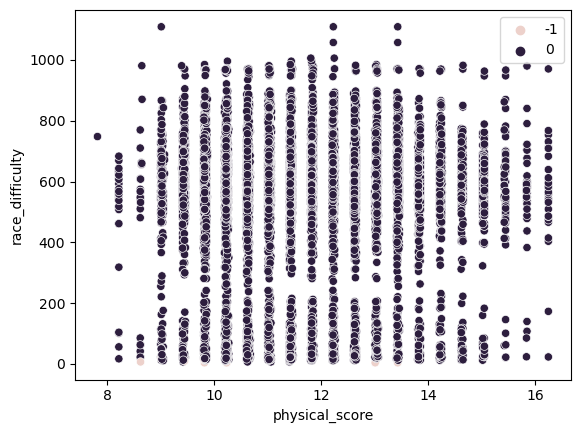

In [42]:
import seaborn
seaborn.scatterplot(data=clustering_features, x="physical_score", y="race_difficulty", hue=dbscan.labels_, legend='full')

In [43]:
print('Silhouette %s' % silhouette_score(data_scaled, dbscan.labels_))

Silhouette 0.797224823349902


Clustering gerarchico

Silhouette score per t=2: 0.8789739421525891
Silhouette score per t=3: 0.8784177926318589
Silhouette score per t=4: 0.8782872317821563
Silhouette score per t=5: 0.7579857604986553
Silhouette score per t=6: 0.7286651295380038
Silhouette score per t=7: 0.6704081244139153
Silhouette score per t=8: 0.6687456448105744
Silhouette score per t=9: 0.6687771108728432
Silhouette score per t=10: 0.6696032676423551
Silhouette score per t=11: 0.6695191655071588
Silhouette score per t=12: 0.6695188035149083
Silhouette score per t=13: 0.6497778489775119
Silhouette score per t=14: 0.6496493508965808


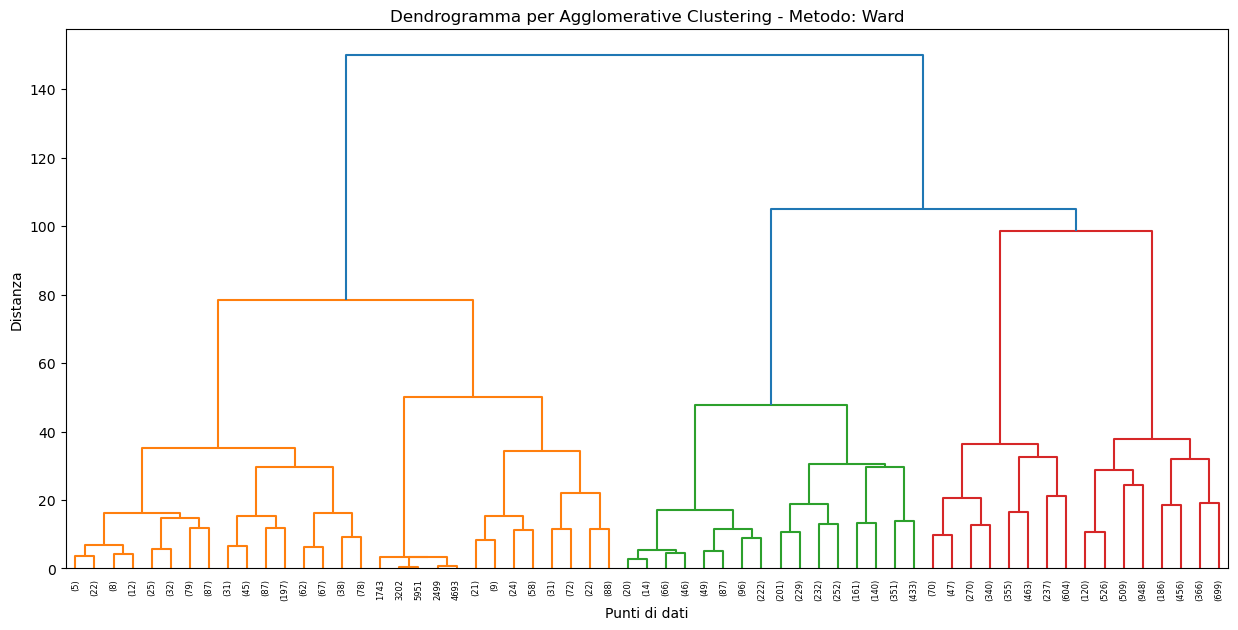

Numero di punti per ciascun cluster con metodo 'ward': {1: 1205, 2: 2599, 3: 2386, 4: 3810}


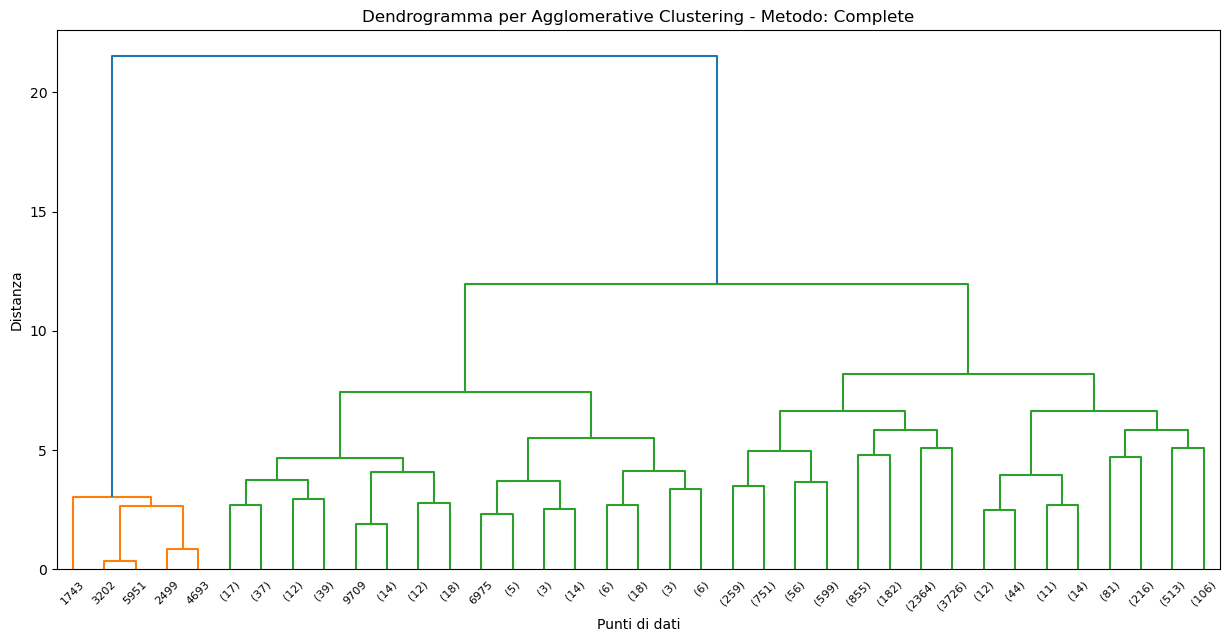

Numero di punti per ciascun cluster con metodo 'complete': {1: 5, 2: 206, 3: 8792, 4: 997}


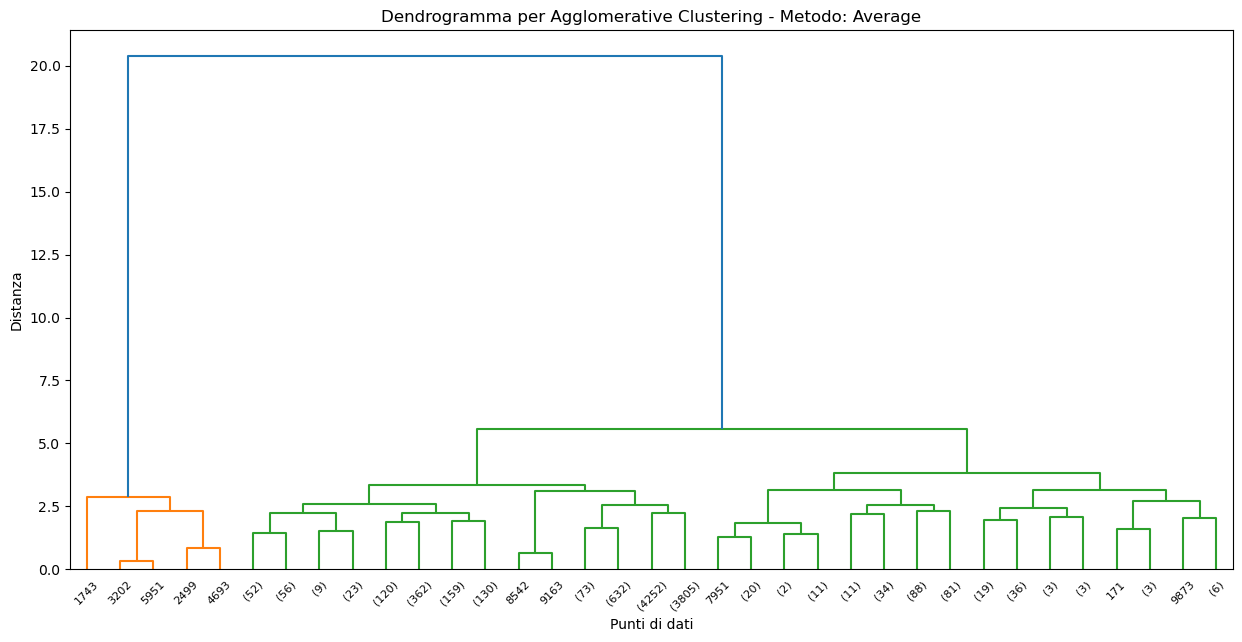

Numero di punti per ciascun cluster con metodo 'average': {1: 5, 2: 9675, 3: 248, 4: 72}


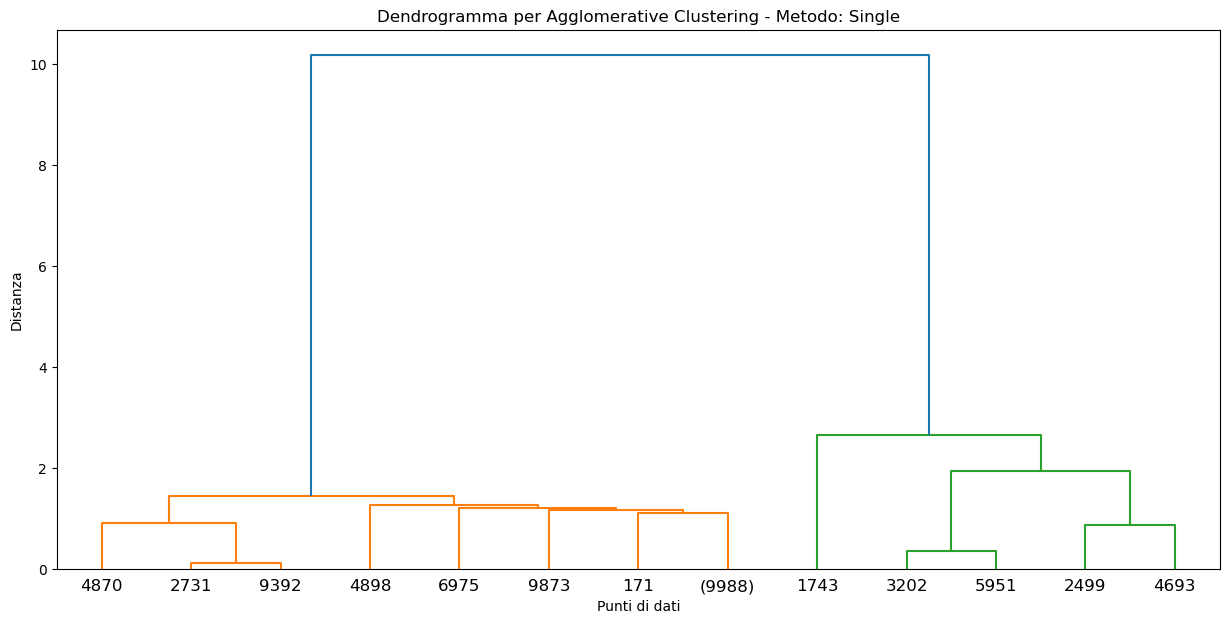

Numero di punti per ciascun cluster con metodo 'single': {1: 9995, 2: 2, 3: 2, 4: 1}


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# metodo di linkage predefinito: 'ward'
linkage_methods = ['ward', 'complete', 'average', 'single']
Z = linkage(data_scaled)

for t in range(2, 15): 
    clusters = fcluster(Z, t=t, criterion='maxclust')
    score = silhouette_score(data_scaled, clusters)
    print(f"Silhouette score per t={t}: {score}")

for method in linkage_methods:

    Z = linkage(data_scaled, method=method)

    plt.figure(figsize=(15, 7))
    plt.title(f"Dendrogramma per Agglomerative Clustering - Metodo: {method.capitalize()}")
    plt.xlabel("Punti di dati")
    plt.ylabel("Distanza")
    dendrogram(Z, truncate_mode='level', p=5)  # Puoi cambiare p per vedere più dettagli
    plt.show()

    t = 4  # numero di cluster
    clusters = fcluster(Z, t=t, criterion='maxclust')

    # Verifica il numero di punti per ciascun cluster
    unique, counts = np.unique(clusters, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    print(f"Numero di punti per ciascun cluster con metodo '{method}':", cluster_counts)

Il metodo ward sembra il più bilanciato tra quelli provati, riuscendo a identificare 5 cluster con distribuzione accettabile dei punti.
Il metodo complete e average tendono a formare un cluster dominante, ma differiscono nella suddivisione degli outliers.
Il metodo single è chiaramente meno adatto, dato che forma un unico grande cluster e considera i pochi punti rimanenti come outliers.

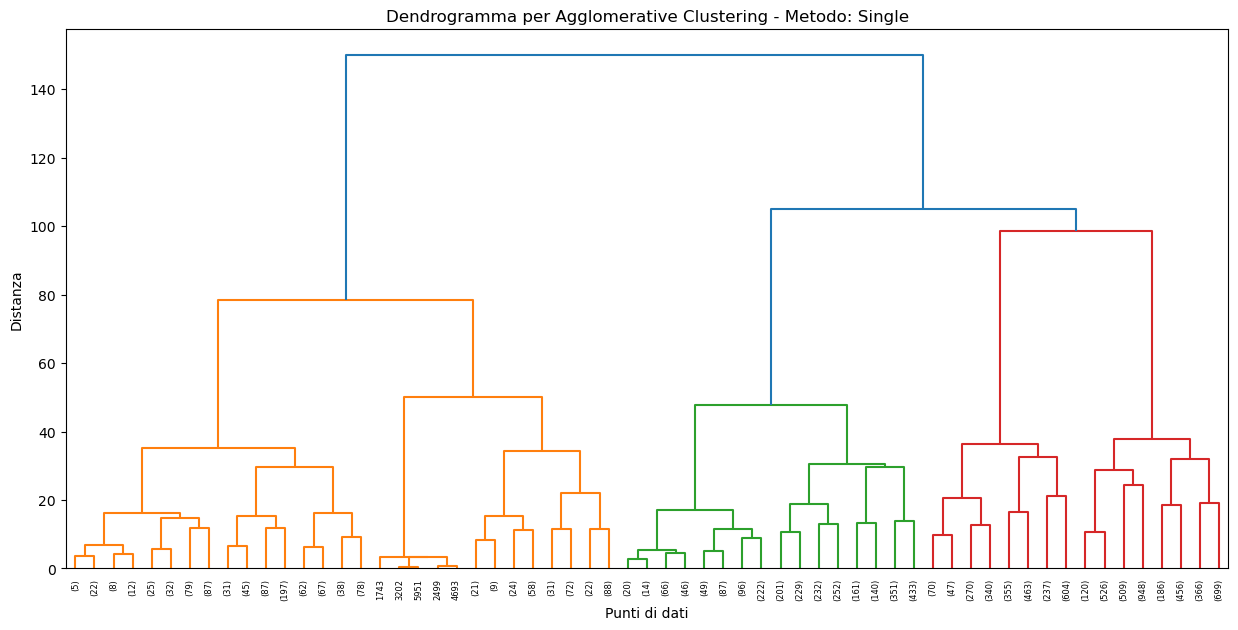

Numero di punti per ciascun cluster con metodo 'ward': {1: 1205, 2: 2599, 3: 2386, 4: 3810}


In [ ]:
Z = linkage(data_scaled, method='ward')

plt.figure(figsize=(15, 7))
plt.title(f"Dendrogramma per Agglomerative Clustering - Metodo: {method.capitalize()}")
plt.xlabel("Punti di dati")
plt.ylabel("Distanza")
dendrogram(Z, truncate_mode='level', p=5)  # Puoi cambiare p per vedere più dettagli
plt.show()
t = 4  # numero di cluster
clusters = fcluster(Z, t=t, criterion='maxclust')

# Verifica il numero di punti per ciascun cluster
unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(f"Numero di punti per ciascun cluster con metodo 'ward':", cluster_counts)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Inizializza il modello, metric='euclidean' per default
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_cluster.fit_predict(data_scaled)

array([0, 2, 3, ..., 0, 1, 3], dtype=int64)

In [ ]:
agg_cluster.labels_

array([0, 2, 3, ..., 0, 1, 3], dtype=int64)

<AxesSubplot:xlabel='physical_score', ylabel='race_difficulty'>

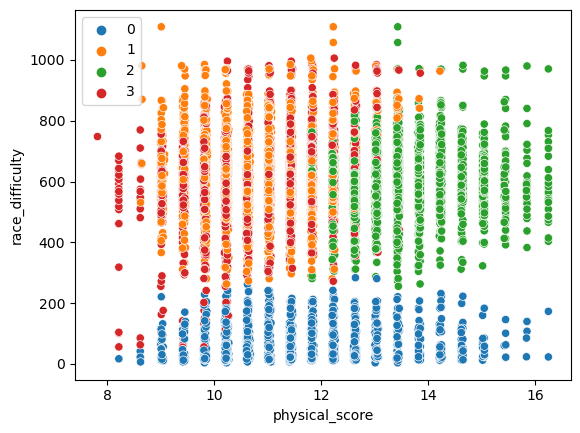

In [ ]:
seaborn.scatterplot(data=clustering_features, x="physical_score", y="race_difficulty", hue=agg_cluster.labels_, legend='full', palette=seaborn.color_palette(n_colors=len(np.unique(agg_cluster.labels_))))